## Algorithm for finding candidate Blazhko peaks 
## and a Blazhko light curve simulation  

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import norm
np.random.seed(42)
%matplotlib inline  

In [2]:
from astroML.utils.decorators import pickle_results
from astroML.datasets import fetch_LINEAR_sample
from astropy.table import Table
from astropy.timeseries import LombScargle
from astroML.time_series import MultiTermFit

### local code (needs to be moved eventually to some src/*.py file)

In [3]:
# given frequency and Lomb-Scargle power, return parameters for a candidate Blazhko peak
def getBlazhkoPeak(freq, LSpow, verbose=False):
    # no. of points
    Npts = np.size(LSpow)
    # index for the main peak
    imax = np.argmax(LSpow)
    # iDelta is the max. width for folding around the main peak
    if (imax < Npts/2):
        iDelta = imax
    else:
        iDelta = Npts - imax
    # folded versions 
    fFolded = freq[imax:imax+1+iDelta]  
    pLeft = LSpow[imax-iDelta:imax+1]  
    pRight = LSpow[imax:imax+1+iDelta]
    pFolded = 0*fFolded
    for i in range(0, iDelta-1):
        # multiply the two branches to increase SNR 
        pFolded[i] = pLeft[-i-1] * pRight[i] 
    # now search for the strongest secondary minimum (after the main one at index=0)
    foundMin = 0
    foldedMax = 0 
    ifoldedMax = 0
    # NB: the first point is the highest by construction (the main peak)
    for i in range(1, iDelta):
        if (pFolded[i] > pFolded[i-1]):
            # the first time we passed through a local minimum
            foundMin = 1
        if foundMin:
            # after the first local minimum, remember the maximum power and its location
            if (pFolded[i] > foldedMax):
                foldedMax = pFolded[i]
                ifoldedMax = i
    # done, return useful quantities       
    fMainPeak = freq[imax] # location of the main peak
    fBlazhkoPeak = fFolded[ifoldedMax] # location of the second strongest peak
    BlazhkoPeriod = 1/(fBlazhkoPeak - fMainPeak) # expression for Blazhko period
    BpowerRatio = pFolded[ifoldedMax]/fFolded[0] # the ratio of power for the 2nd and 1st peaks
    # now compare the second peak's strength to the power at larger frequencies (presumably noise)
    powerFar = pFolded[fFolded>fBlazhkoPeak]  # frequencies beyond the second peak
    powerFarMedian = np.median(powerFar)      # the median power
    powerFarRMS = np.std(powerFar)            # standard deviation, i.e. "sigma"
    Bsignificance = (pFolded[ifoldedMax]-powerFarMedian)/powerFarRMS  # how many sigma above median?
    if (verbose):
        print('main frequency (1/day):', fMainPeak)
        print('detected second peak at index:', ifoldedMax)
        print('Blazhko peak frequency (1/day):', fBlazhkoPeak)
        print('Blazhko peak relative strength:', BpowerRatio)
        print('median power beyond Blazhko peak:', powerFarMedian)
        print('power rms beyond Blazhko peak:', powerFarRMS)
        print('Blazhko peak significance:', Bsignificance)
        print('Blazhko period (day):', BlazhkoPeriod)
    return fFolded, pFolded, fMainPeak, fBlazhkoPeak, BlazhkoPeriod, BpowerRatio, Bsignificance

In [4]:
def LINEARLS(LINEARmetadata, LINEARlightcurves, LINEARid, plot=True, verbose=True):
    # for returning analysis results
    PeriodComparison = {}
    # for later assertions and sanity checks...
    PeriodComparison['LINEARid'] = LINEARid
    if verbose:
        print('------------------------------------------------------------')
        print('Period and light curve analysis for LINEAR ID =', LINEARid)
    ### first prepare light curve data
    # LINEAR light curve for this star (specified by provided LINEARid)
    tL, mL, mLerr = LINEARlightcurves[LINEARid].T

    ### now compute periods (using LombScargle from astropy.timeseries)
    nterms = 3
    # LINEAR-only period
    if verbose:
        print('  computing LINEAR period...')
    Plinear, fL, pL = doPeriods(tL, mL, mLerr, nterms, lsPS=True)    
    PeriodComparison['Plinear'] = Plinear
    
    ### period and chi2 analysis
    # evaluate phased light curves and compute chi2 for models obtained using both periods:
    #    the best-fit period for each survey, and the mean period
    # compute models (now can take more Fourier terms than when computing period)
    ntermsModels = 6
    # first LINEAR light curve
    LINEAR_Plinear = LCanalysisFromP(tL, mL, mLerr, Plinear, ntermsModels)
    LINEAR_Plinear['obsTimes'] = tL
    if verbose:
        print(' LINEAR light curve analysis:')
        print('  Nlinear=', np.size(tL), 'rms mag D-M:', LINEAR_Plinear['rms'])
        print('      chi2dof:', LINEAR_Plinear['chi2dof'])
        print('       robust:', LINEAR_Plinear['chi2dofR'])
    PeriodComparison['NdataLINEAR'] = np.size(tL)
    PeriodComparison['LPlin_rmsdmag'] = LINEAR_Plinear['rms']
    PeriodComparison['LPlin_chi2dof'] = LINEAR_Plinear['chi2dof']
    PeriodComparison['LPlin_chi2dofR'] = LINEAR_Plinear['chi2dofR']
    PeriodComparison['Lmmax'] = LINEAR_Plinear['mmax']
    PeriodComparison['Lampl'] = LINEAR_Plinear['A']
    
    ## plot light curve 
    if plot:
        makeLCplot(LINEAR_Plinear)

    return PeriodComparison, fL, pL, LINEAR_Plinear 

# similar to doPeriodsOrig(), but first try with auto frequency grid
# and then "zoom-in" around the highest LS power peak 
# note: freqFac=1.02 allows search for Blazhko periods longer than 50*basic period, so ~25 days and longer
def doPeriods(time, mag, magErr, nterms, lsPS=False, nyquist=100, freqFac=1.02):
    try:
        ls = LombScargle(time, mag, magErr, nterms=nterms) # set up a LombScargle object to model the frequency and power
        frequencyAuto, powerAuto = ls.autopower(nyquist_factor=nyquist) # calculate the frequency and power
        best_freq = frequencyAuto[np.argmax(powerAuto)]
        frequency = np.arange(best_freq/freqFac, best_freq*freqFac, 5e-6)
        power = ls.power(frequency)  # compute LS periodogram again
        period = 1. / frequency
        best_period = period[np.argmax(power)] # choosing the period with the highest power
        if lsPS: 
            return best_period, frequency, power
        else:
            return best_period
    except:
        print('failed for ID=', Lid)
        return 'Error in doPeriods'
    
# given (time, mag, magErr) data, and some period P, 
# return various results of light curve analysis:
# 
def LCanalysisFromP(time, mag, magErr, P, ntermsModels):
    LCanalysisResults = {}
    # first compute best-fit models for given period
    mtf = MultiTermFit(2*np.pi/P, ntermsModels)
    mtf.fit(time, mag, magErr)
    a, b, c = mtf.predict(1000, return_phased_times=True, adjust_offset=False)
    LCanalysisResults['modelPhaseGrid'] = a
    LCanalysisResults['modelFit'] = b
    LCanalysisResults['dataPhasedTime']= c
    # light curve template normalization: mag = A * t(phi) + mmax, where
    # phi is phase, t is template, A is amplitude and mmax is the magnitude at 
    #       maximum light (note: numerically it is the minimum value of mag)
    # also: we are using models for computing amplitude and mmax to avoid noise in data
    A = np.max(b) - np.min(b) 
    mmax = np.min(b) 
    LCanalysisResults['A'] = A
    LCanalysisResults['mmax'] = mmax
    LCanalysisResults['modTemplate'] = (b - mmax)/A 
    LCanalysisResults['dataTemplate'] = (mag - mmax)/A 
    LCanalysisResults['dataTemplateErr'] = magErr/A 
    # for chi2, first interpolate model fit to phases of data values
    modelFit2data = np.interp(c, a, LCanalysisResults['modTemplate'])
    LCanalysisResults['modelFit2data'] = modelFit2data 
    delmag = LCanalysisResults['dataTemplate'] - modelFit2data
    LCanalysisResults['rms'] = sigG(delmag)
    LCanalysisResults['chi'] = delmag/LCanalysisResults['dataTemplateErr']
    LCanalysisResults['chi2dof'] = np.sum(LCanalysisResults['chi']**2)/np.size(LCanalysisResults['chi'])
    LCanalysisResults['chi2dofR'] = sigG(LCanalysisResults['chi'])
    return LCanalysisResults 

In [5]:
# a little helper: sort array a, and reorder b, c, too. 
def sort3arr(a, b, c):
    ind = np.argsort(a)
    return a[ind], b[ind], c[ind]

def sort4arr(a, b, c, d):
    ind = np.argsort(a)
    return a[ind], b[ind], c[ind], d[ind]

def sigG(x):
    return 0.741*(np.percentile(x,75)-np.percentile(x,25))

In [6]:
# L1 = results of period analysis
def makeLCplot(L1, plotrootname='LCplot', plotSave=False):
    fig, ax = plt.subplots(1,1, figsize=(7,5))  

    ax.set(xlabel='data phased with best-fit LINEAR period', ylabel='LINEAR normalized light curve')
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(1.3, -0.3)
    # data
    xx, yy, zz = sort3arr(L1['dataPhasedTime'], L1['dataTemplate'], L1['dataTemplateErr'])
    ax.errorbar(xx, yy, zz, fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.3)
    # fit for Plinear
    ax.plot(L1['modelPhaseGrid'], L1['modTemplate'], 'red', markeredgecolor='red', lw=1, fillstyle='top', linestyle='dashed')
    
    if plotSave:
        plotName = plotrootname + '.png'
        plt.savefig(plotName, dpi=600)
        print('saved plot as:', plotName) 
    plt.show()     
    return

# L1 = results of period analysis
def makeLCplotBySeason(id0, L1, plotrootname='LCplotBySeason', plotSave=False):
    
    fig = plt.figure(figsize=(10, 12))
    fig.subplots_adjust(hspace=0.2, bottom=0.06, top=0.94, left=0.12, right=0.94)
    
    def plotPanel(ax, L1, season):
        ax.set(xlabel='phase', ylabel='normalized phased light curve')
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(1.3, -0.4)
        # fit for Plinear
        ax.plot(L1['modelPhaseGrid'], L1['modTemplate'], 'red', markeredgecolor='red', lw=1, fillstyle='top', linestyle='dashed')
    
        # data
        xx, yy, zz, ww = sort4arr(L1['dataPhasedTime'], L1['dataTemplate'], L1['dataTemplateErr'], L1['obsTimes'])
        tSmin = 52520 + (season-1)*365
        tSmax = 52520 + season*365
        xxS = xx[(ww>tSmin)&(ww<tSmax)]
        yyS = yy[(ww>tSmin)&(ww<tSmax)]
        zzS = zz[(ww>tSmin)&(ww<tSmax)]
        wwS = ww[(ww>tSmin)&(ww<tSmax)]
        ax.errorbar(xxS, yyS, zzS, fmt='.b', ecolor='blue', lw=1, ms=4, capsize=1.5, alpha=0.3)
        textString = "LINEAR season " + str(season)
        ax.text(0.03, 0.96, textString, ha='left', va='top', transform=ax.transAxes)
        textString = "MJD=" + str(tSmin) + ' to ' + str(tSmax)
        ax.text(0.53, 0.96, textString, ha='left', va='top', transform=ax.transAxes)

        
    # plot each season separately 
    for season in range(1,7):
        # plot the power spectrum
        ax = fig.add_subplot(321 + season-1)
        plotPanel(ax, L1, season)
        if (season==1):
            ax.set(title='LINEAR object {0}'.format(id0))

    if plotSave:
        plotName = plotrootname + '.png'
        plt.savefig(plotName, dpi=600)
        print('saved plot as:', plotName) 
    plt.show()     
    return

### retrieve LINEAR light curve data for a given LINEAR ID

In [7]:
# LINEAR dataset
LINEARlightcurves = fetch_LINEAR_sample() # getting the data from the astroML library

In [8]:
### select a star from the "good" sample of RR Lyrae
# read data for the master sample of 5204 stars with reliable and reproducible LINEAR periods
colnames = ['ID','Porig','Pnew','ra','dec', 'ug','gi','iK','JK','logP','Ampl','skew','kurt','magMed','nObs','LCtype']
L = Table.read('../outputs/LINEAR_Periods_nterm3.txt', format='ascii', names=colnames)
Pratio = L['Porig']/L['Pnew'] 
Lok = L[(Pratio>0.99)&(Pratio<1.01)]  # reproducible periods
# select RR Lyrae using g-i color and previous light curve classification
Lrrlyr = Lok[(Lok['gi']>-0.5)&(Lok['gi']<0.4)&(Lok['LCtype']>0)&(Lok['LCtype']<3)]
len(Lrrlyr)

2710

------------------------------------------------------------
Period and light curve analysis for LINEAR ID = 1092244
  computing LINEAR period...
 LINEAR light curve analysis:
  Nlinear= 590 rms mag D-M: 0.1052893518009241
      chi2dof: 2.3236681011883444
       robust: 1.1614976528732004


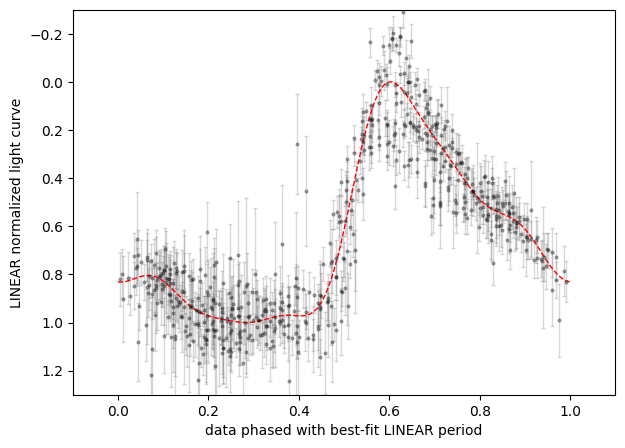

In [9]:
# id0 = '24107664' # chi2 < 1, probably overestimated uncertainties; clean Blazhko, Bsignificance=16!
# id0 = '10022663' # Bsignificance=6.4 but barely believable (perhaps signal in season 6)
# id0 = '104455'   # problems with periodogram, it looks like 1 day alias
# id0 = '18525697' # Blazhko star from periodogram, but light curve looks normal (seasons plot reveals Blazhko)
id0 = '1092244'  # Blazhko star; a great example of amplitude modulation 
# id0 = '62892'    # Ema's star with problematic PS, also Blazhko
Pcomparison, fL, pL, LINEAR_Plinear = LINEARLS(Lrrlyr, LINEARlightcurves, id0) 

In [10]:
fFolded, pFolded, fMainPeak, fBlazhkoPeak, BlazhkoPeriod, BpowerRatio, Bsignificance = getBlazhkoPeak(fL, pL, verbose=True)

main frequency (1/day): 1.5396573418231358
detected second peak at index: 546
Blazhko peak frequency (1/day): 1.5423873418231537
Blazhko peak relative strength: 0.15280872431447295
median power beyond Blazhko peak: 0.002867233397675398
power rms beyond Blazhko peak: 0.016840417837502265
Blazhko peak significance: 13.800479485145624
Blazhko period (day): 366.3003662979666


LINEAR ID= 1092244


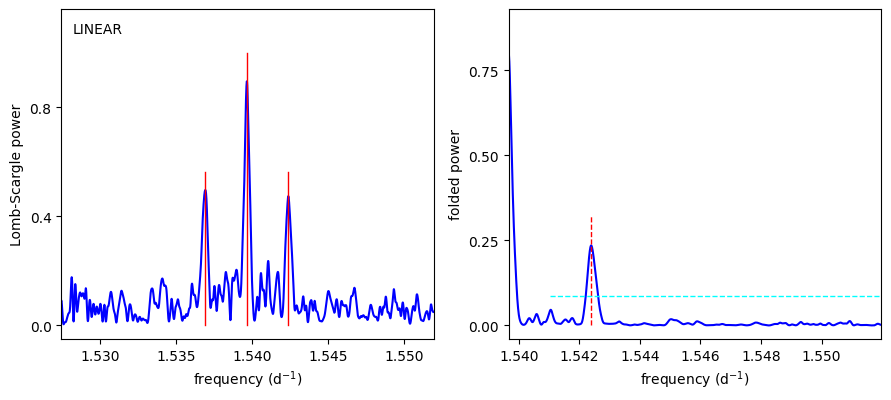

In [11]:
print('LINEAR ID=', id0)
flin = fL[np.argmax(pL)]

## at some point, we will read periodograms back from files...
fig = plt.figure(figsize=(10, 12))
fig.subplots_adjust(hspace=0.1, bottom=0.06, top=0.94, left=0.12, right=0.94)

# plot the power spectrum
ax = fig.add_subplot(321)

ax.plot(fL, pL, c='b')
ax.plot([flin, flin], [0,1], lw = 1, c='r')
ax.plot([fBlazhkoPeak, fBlazhkoPeak], [0,0.7*np.max(pFolded)], lw = 1, c='r')
ax.plot([2*flin-fBlazhkoPeak, 2*flin-fBlazhkoPeak], [0,0.7*np.max(pFolded)], lw = 1, c='r')

ax.text(0.03, 0.96, "LINEAR", ha='left', va='top', transform=ax.transAxes)

fac = 1.008
ax.set_xlim(flin/fac, flin*fac)
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

ylim = ax.get_ylim()
ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))
ax.set_ylabel('Lomb-Scargle power')
ax.set_xlabel('frequency (d$^{-1}$)')

# plot folder power spectrum
ax = fig.add_subplot(322)

ax.plot(fFolded, pFolded, c='b')
ax.plot([fBlazhkoPeak, fBlazhkoPeak], [0,0.4*np.max(pFolded)], lw = 1, ls='--', c='r')

powerFar = pFolded[fFolded>fBlazhkoPeak]  # frequencies beyond the second peak
powerFarMedian = np.median(powerFar)      # the median power
powerFarRMS = np.std(powerFar)            # standard deviation, i.e. "sigma"
noise5sig = powerFarMedian+5*powerFarRMS
ax.plot([flin+0.5*(fBlazhkoPeak-flin), flin*fac], [noise5sig, noise5sig], lw = 1, ls='--', c='cyan')

ax.set_xlim(flin, flin*fac)
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

ylim = ax.get_ylim()
ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))
ax.set_ylabel('folded power')
ax.set_xlabel('frequency (d$^{-1}$)')

plt.show()

In [12]:
# generate a simulated light curve with the same main and Blazhko frequencies
time = np.linspace(0, 500, 100000)
LC = np.sin(2*3.14158*time*flin) 
LCb = LC + 0.3*np.sin(2*3.14158*time*(2*flin-fBlazhkoPeak)) 
LCb = LCb + 0.3*np.sin(2*3.14158*time*fBlazhkoPeak) 
LCb = LCb/np.max(LCb) 

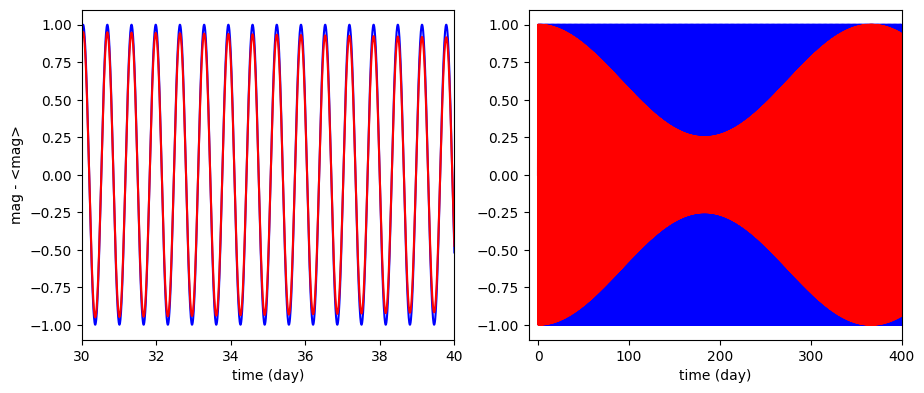

In [13]:
# plot folder power spectrum
fig = plt.figure(figsize=(10, 12))
fig.subplots_adjust(hspace=0.1, bottom=0.06, top=0.94, left=0.12, right=0.94)

ax = fig.add_subplot(321)
ax.plot(time, LC, c='b')
ax.plot(time, LCb, c='r')
ax.set_xlim(30,40)
ax.set_ylabel('mag - <mag>')
ax.set_xlabel('time (day)')

ax = fig.add_subplot(322)
ax.plot(time, LC, c='b')
ax.plot(time, LCb, c='r')
ax.set_xlim(-10, 400)
ax.set_xlabel('time (day)')
 

plt.show()

## now plot phase curves for each LINEAR observing season 

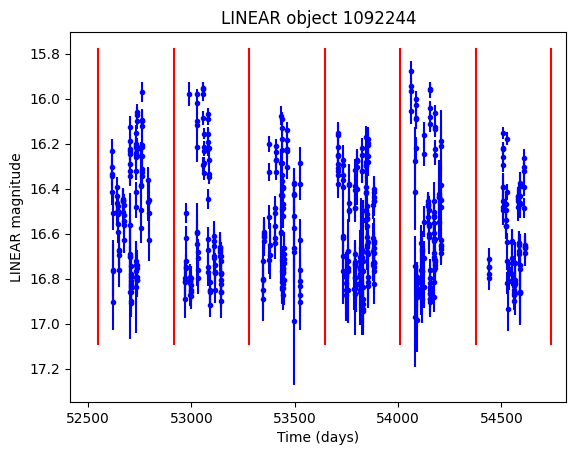

In [14]:
## plot LINEAR light curve
tL, mL, mLerr = LINEARlightcurves[id0].T
fig, ax = plt.subplots()
ax.errorbar(tL, mL, mLerr, fmt='.b', ecolor='blue')
ax.set(xlabel='Time (days)', ylabel='LINEAR magnitude',
       title='LINEAR object {0}'.format(id0))
ax.invert_yaxis()
plt.xlim(np.min(tL)-200, np.max(tL)+200)

for s in range(1, 8):
    tS = 52550 + (s-1)*365
    ax.plot([tS, tS], [np.min(mL)-0.1, np.max(mL)+0.1], c='r')

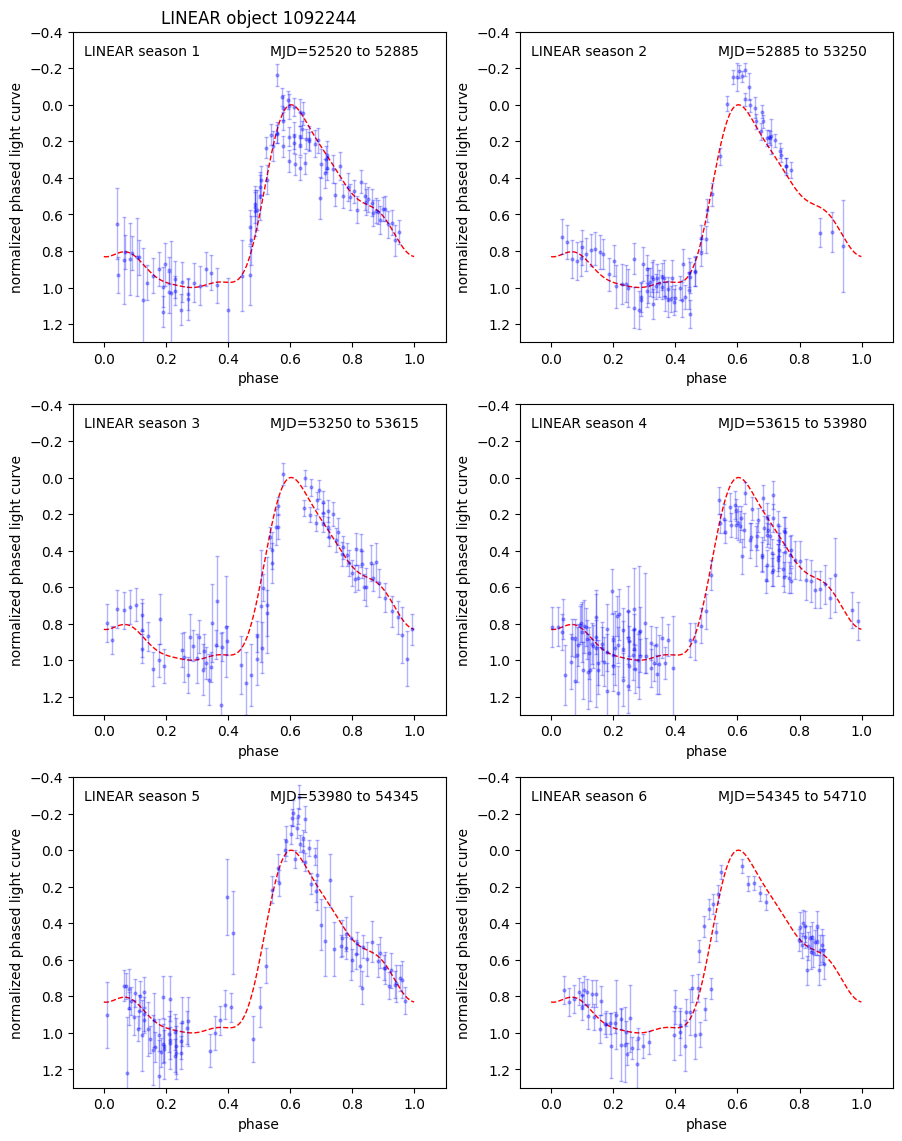

In [15]:
makeLCplotBySeason(id0, LINEAR_Plinear)

## now compute Blazhko parameters for all RR Lyrae stars

In [ ]:
Bpowrat = 0*Lrrlyr['gi']
Bsig = 0*Lrrlyr['gi']
Nstar = len(Lrrlyr)
for iid in range(0,Nstar):
    Lid = Lrrlyr['ID'][iid]
    Pcomparison, fL, pL, LINEAR_Plinear = LINEARLS(Lrrlyr, LINEARlightcurves, Lid, plot=False, verbose=False) 
    fF, pF, fMainPeak, fBlazhkoPeak, BlazhkoPeriod, Bpowrat[iid], Bsig[iid] = getBlazhkoPeak(fL, pL)
    if (iid%100==0):  
        print(iid, Lid, BlazhkoPeriod, Bpowrat[iid], Bsig[iid])

0 29848 352.7336860647086 0.040252391828115526 6.251189951608942
100 1426563 369.00369003448293 0.19076864920241102 9.178228141741236
200 2288347 364.29872495207604 0.035139870357061724 6.077689080738284
300 2989064 368.32412522778964 0.04197368735911469 7.659499097715022
